In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import time
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from pythonlibs.torch_lib1 import *
from torchviz import make_dot
from torchinfo import summary

In [20]:
# matplotlibの初期設定
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['font.size'] = 14

In [2]:
torch.cuda.is_available()

True

# 適合的プーリング関数

In [3]:
# nn.AdaptiveAvgPool2d定義
p = nn.AdaptiveAvgPool2d((1, 1))
print(p)

# 線形関数の定義
l1 = nn.Linear(32, 10)
print(l1)

AdaptiveAvgPool2d(output_size=(1, 1))
Linear(in_features=32, out_features=10, bias=True)


In [4]:
# 事前学習済みモデルのシュミレーション
input = torch.randn(100, 32, 16, 16 )
m1 = p(input)
m2 = m1.view(m1.shape[0], -1)
m3 = l1(m2)


print(m1.shape)
print(m2.shape)
print(m3.shape)

torch.Size([100, 32, 1, 1])
torch.Size([100, 32])
torch.Size([100, 10])


## データ準備

In [5]:
# Transformsの定義

# 学習データ用
transform_train = transforms.Compose([
    transforms.Resize(112),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing()
])

# 検証用データ用
transform = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [6]:
# データセット

root = './hidden_data/'
train_set = datasets.CIFAR10(root, train=True, transform=transform_train)
test_set = datasets.CIFAR10(root, train=False, transform=transform)


In [7]:
# バッチサイズ
batch_size = 50

# データローダー
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)


In [8]:
# 学習済みモデルのロード
# pretrained = True で学習済みパラメータも一緒に読み込む
net = models.resnet18(weights = 'IMAGENET1K_V1')

In [9]:
# resnet18の構造を見る
# print(net)

In [14]:
device = 'cuda:0'
net = net.to(device)
summary(net, (100, 3, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [100, 10]                 --
├─Conv2d: 1-1                            [100, 64, 56, 56]         9,408
├─BatchNorm2d: 1-2                       [100, 64, 56, 56]         128
├─ReLU: 1-3                              [100, 64, 56, 56]         --
├─MaxPool2d: 1-4                         [100, 64, 28, 28]         --
├─Sequential: 1-5                        [100, 64, 28, 28]         --
│    └─BasicBlock: 2-1                   [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-1                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-3                    [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-4                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-6                    [100, 64, 28, 28]         --
│

In [11]:
# net最後の線形関数の確認
print(net.fc)
print(net.fc.in_features)

Linear(in_features=512, out_features=1000, bias=True)
512


## 最終レイヤー関数の付け替え

In [12]:
# seed_fix
torch_seed()

# 最終レイヤー関数の入力数
fc_in_features = net.fc.in_features

n_output =10

# 最終レイヤー関数の付け替え
net.fc = nn.Linear(fc_in_features, n_output)
print(net.fc)

Linear(in_features=512, out_features=10, bias=True)


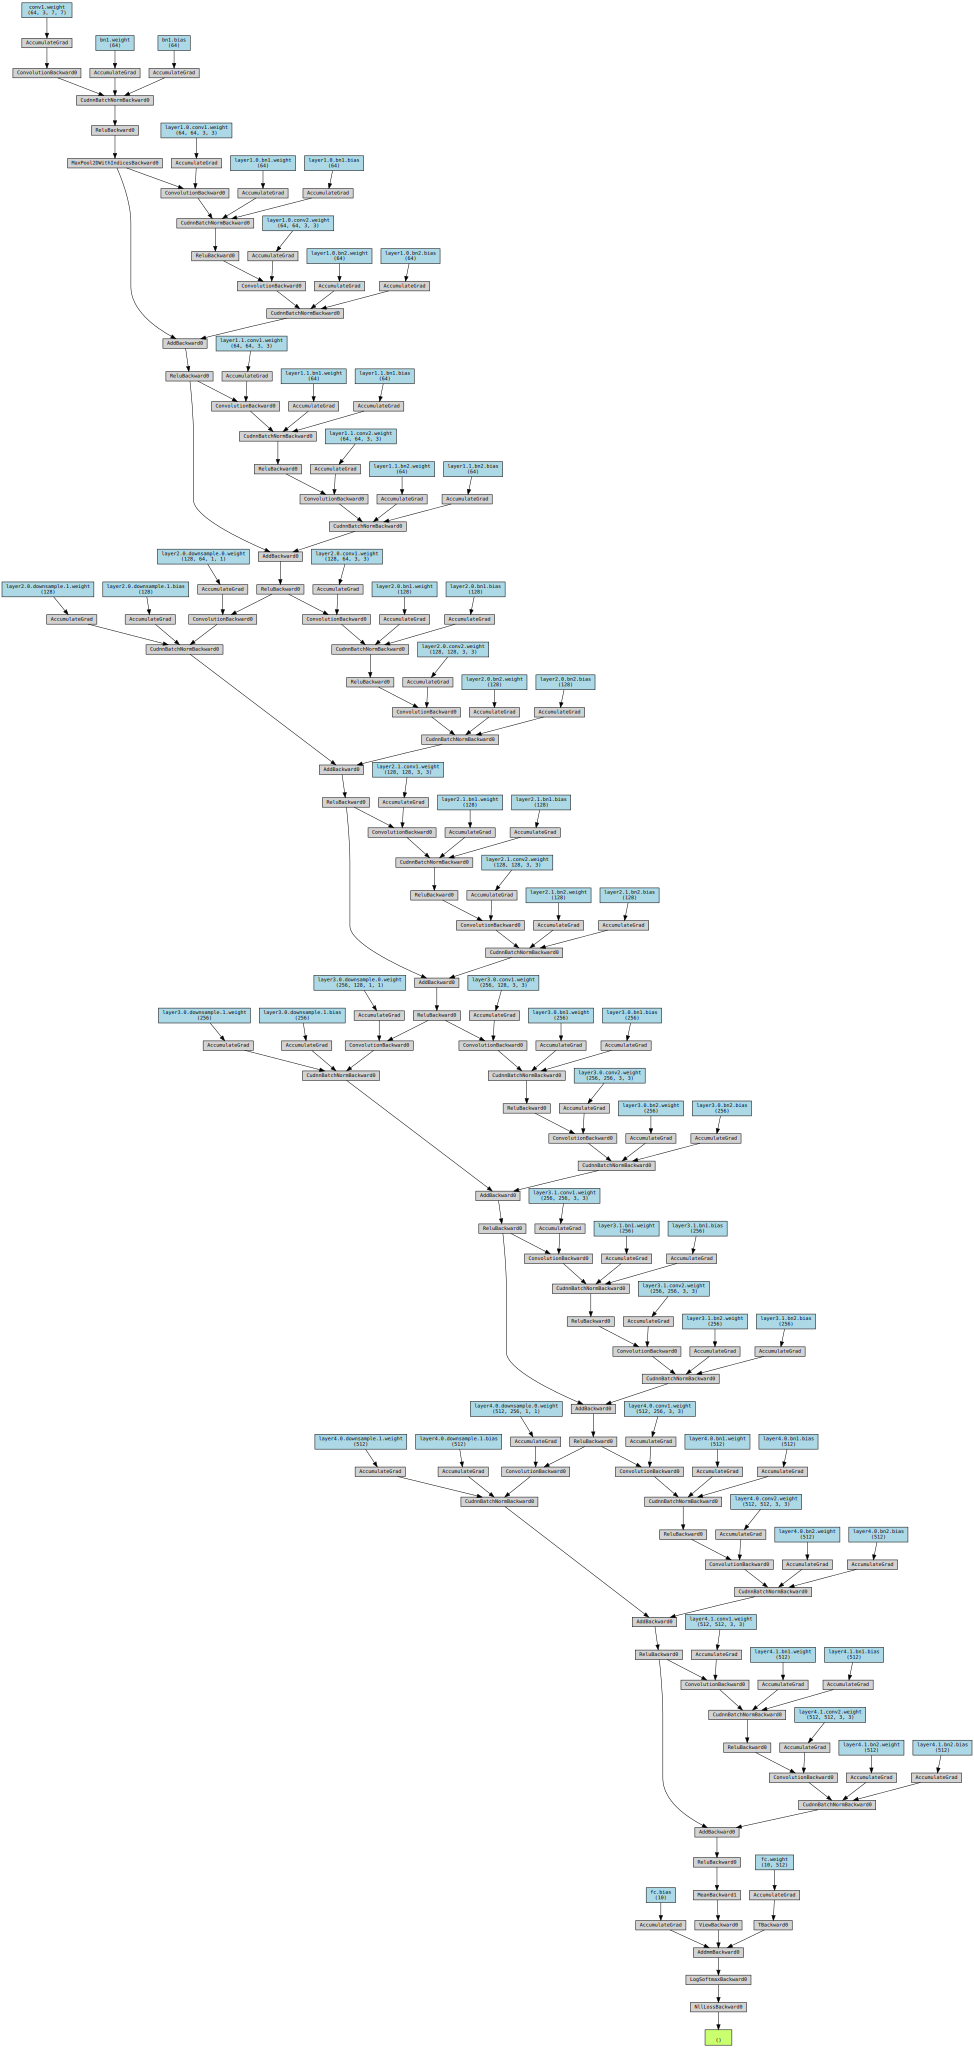

In [15]:
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
make_dot(loss, dict(net.named_parameters()))

In [16]:
torch_seed()

net = models.resnet18(weights= 'IMAGENET1K_V1')

fc_in_features = net.fc.in_features
net.fc = nn.Linear(fc_in_features, n_output)

net = net.to(device)

criterion = nn.CrossEntropyLoss()

lr = 0.001

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

history = torch.zeros((0, 5))

In [18]:
start = time.time()

num_epoch = 10

history = fit(net, optimizer, criterion, num_epoch, train_loader, test_loader, device, history)

end = time.time()

print(f'実行時間は：{end-start}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.41708 acc: 0.85484 val_loss: 0.25053, val_acc: 0.91300


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.29274 acc: 0.89954 val_loss: 0.19954, val_acc: 0.93040


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.24136 acc: 0.91680 val_loss: 0.18919, val_acc: 0.93440


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.20673 acc: 0.92832 val_loss: 0.17346, val_acc: 0.94050


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.18042 acc: 0.93814 val_loss: 0.16940, val_acc: 0.94170


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.16021 acc: 0.94524 val_loss: 0.16812, val_acc: 0.94350


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.14110 acc: 0.95188 val_loss: 0.16693, val_acc: 0.94560


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.13265 acc: 0.95578 val_loss: 0.15896, val_acc: 0.94940


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.11906 acc: 0.95932 val_loss: 0.16215, val_acc: 0.94550


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.10927 acc: 0.96284 val_loss: 0.16032, val_acc: 0.95040
実行時間は：502.84002470970154


初期状態: 損失: 0.25053 精度: 0.91300
最終状態: 損失: 0.16032 精度: 0.95040


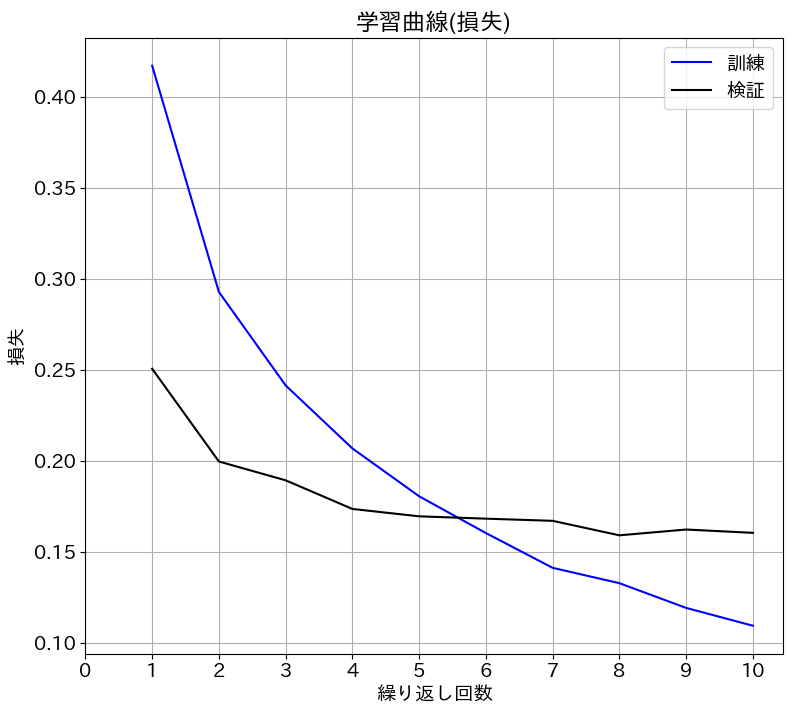

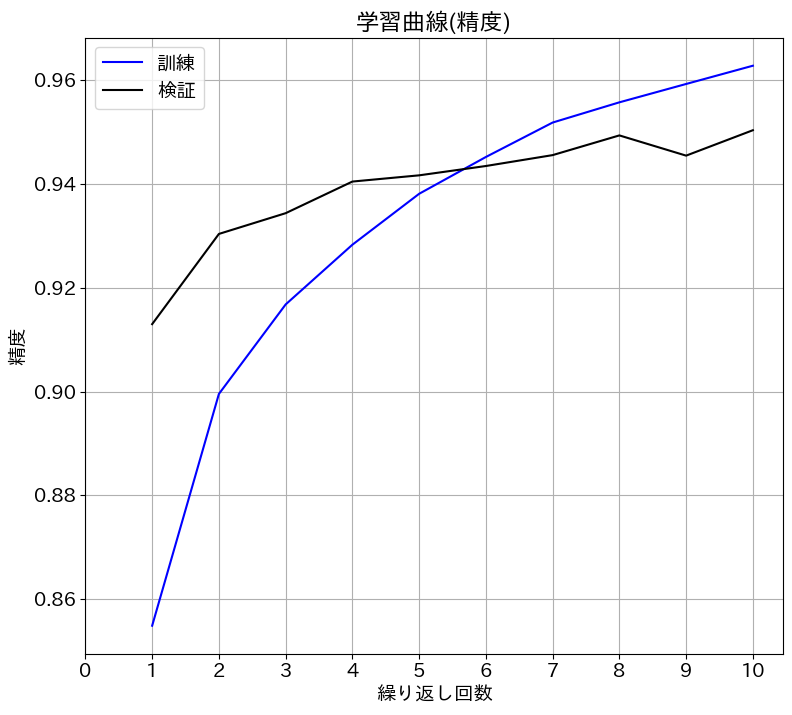

In [21]:
evaluate_history(history)

## VGG-19-BNの場合

In [36]:
net = models.vgg19_bn(weights='IMAGENET1K_V1')

In [26]:
summary(net, (1, 3, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 3, 3]            --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 64, 112, 112]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 112, 112]         128
│    └─ReLU: 2-6                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-7                    [1, 64, 56, 56]           --
│    └─Conv2d: 2-8                       [1, 128, 56, 56]          73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 56, 56]          256
│    └─ReLU: 2-10                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 128, 56, 56]          147,

In [28]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [30]:
# AdaptiveAvgPool2dが7x7なので512x7x7=25088のベクトルに変換される。
# その後、classifierの[0]のLinearに渡される。

print(net.classifier[0])

Linear(in_features=25088, out_features=4096, bias=True)


In [37]:
# 最終レイヤーの付け替え
torch_seed()

in_features = net.classifier[6].in_features

net.classifier[6] = nn.Linear(in_features, n_output)

# features最後のMaxPool2dを外す。
net.features = net.features[:-1]

net.avgpool = nn.Identity()
net.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

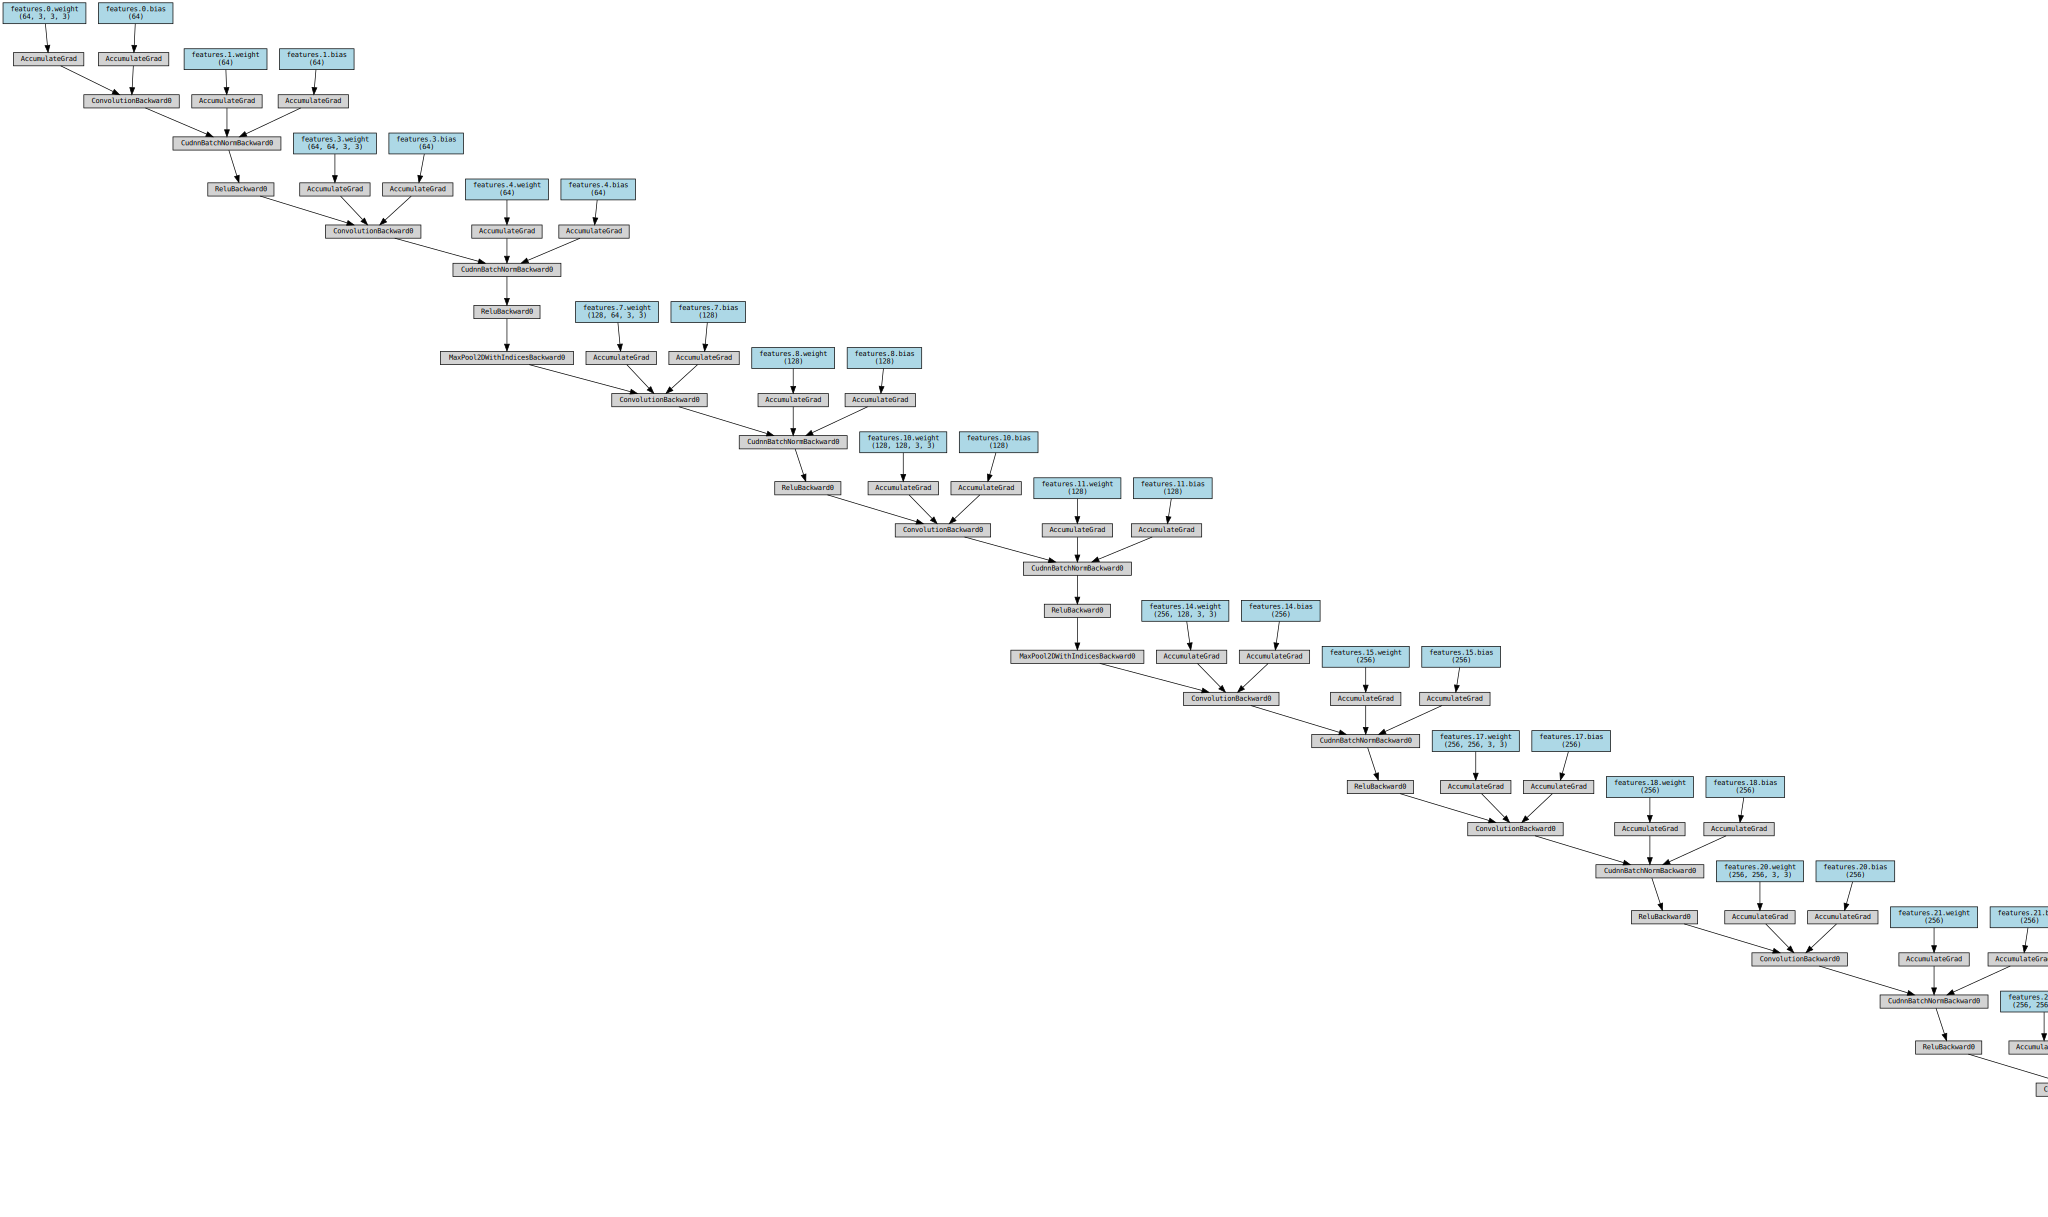

In [40]:
criterion = nn.CrossEntropyLoss()
net = net.to(device)
loss = eval_loss(test_loader, device, net, criterion)
make_dot(loss, dict(net.named_parameters()))

In [45]:
# モデル等の設定
torch_seed()

net = models.vgg19_bn(weights='IMAGENET1K_V1')
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, n_output)

# features最後のMaxPool2dを外す。
net.features = net.features[:-1]
net.avgpool = nn.Identity()

net = net.to(device)

criterion = nn.CrossEntropyLoss()

lr = 0.001

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

history = torch.zeros((0, 5))

In [46]:
start = time.time()
num_epoch = 5
history = fit(net, optimizer, criterion, num_epoch, train_loader, test_loader, device, history)
end = time.time()
print(f'実行時間は：{end - start}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.49795 acc: 0.83226 val_loss: 0.18280, val_acc: 0.93820


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.23838 acc: 0.91920 val_loss: 0.15064, val_acc: 0.94880


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.18257 acc: 0.93788 val_loss: 0.13216, val_acc: 0.95260


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.15147 acc: 0.94880 val_loss: 0.12602, val_acc: 0.95840


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.13251 acc: 0.95546 val_loss: 0.12043, val_acc: 0.95930
実行時間は：797.1948363780975


初期状態: 損失: 0.18280 精度: 0.93820
最終状態: 損失: 0.12043 精度: 0.95930


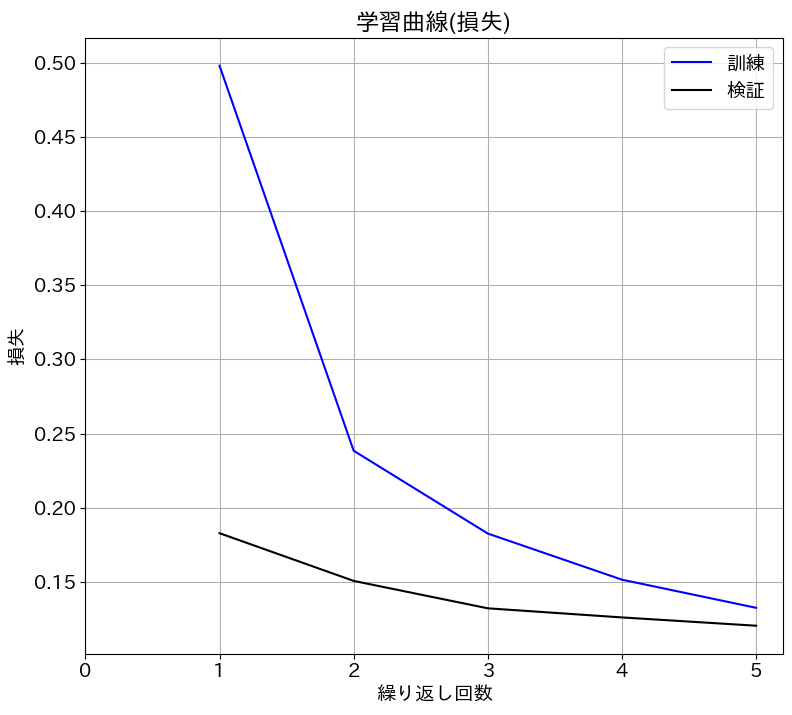

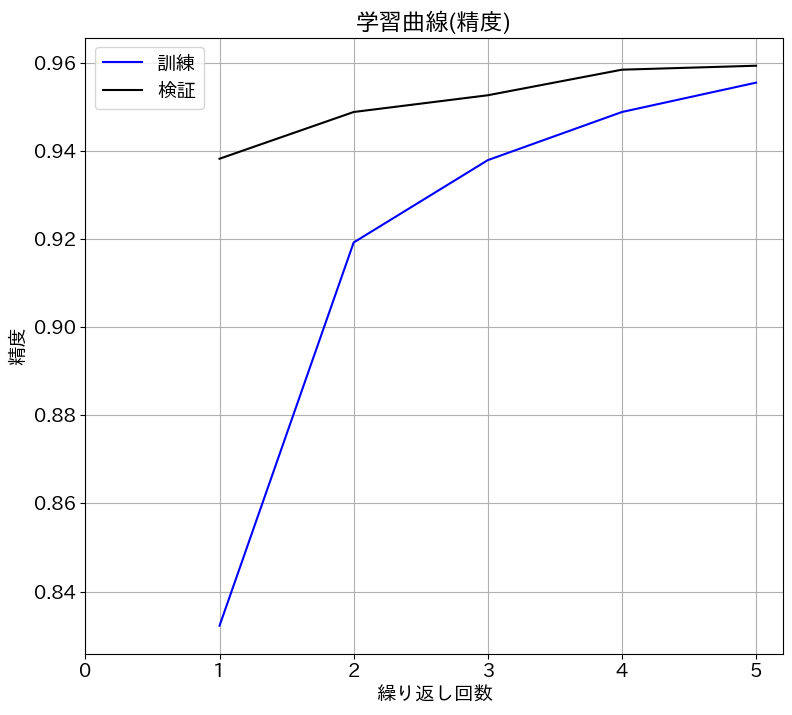

In [47]:
evaluate_history(history)

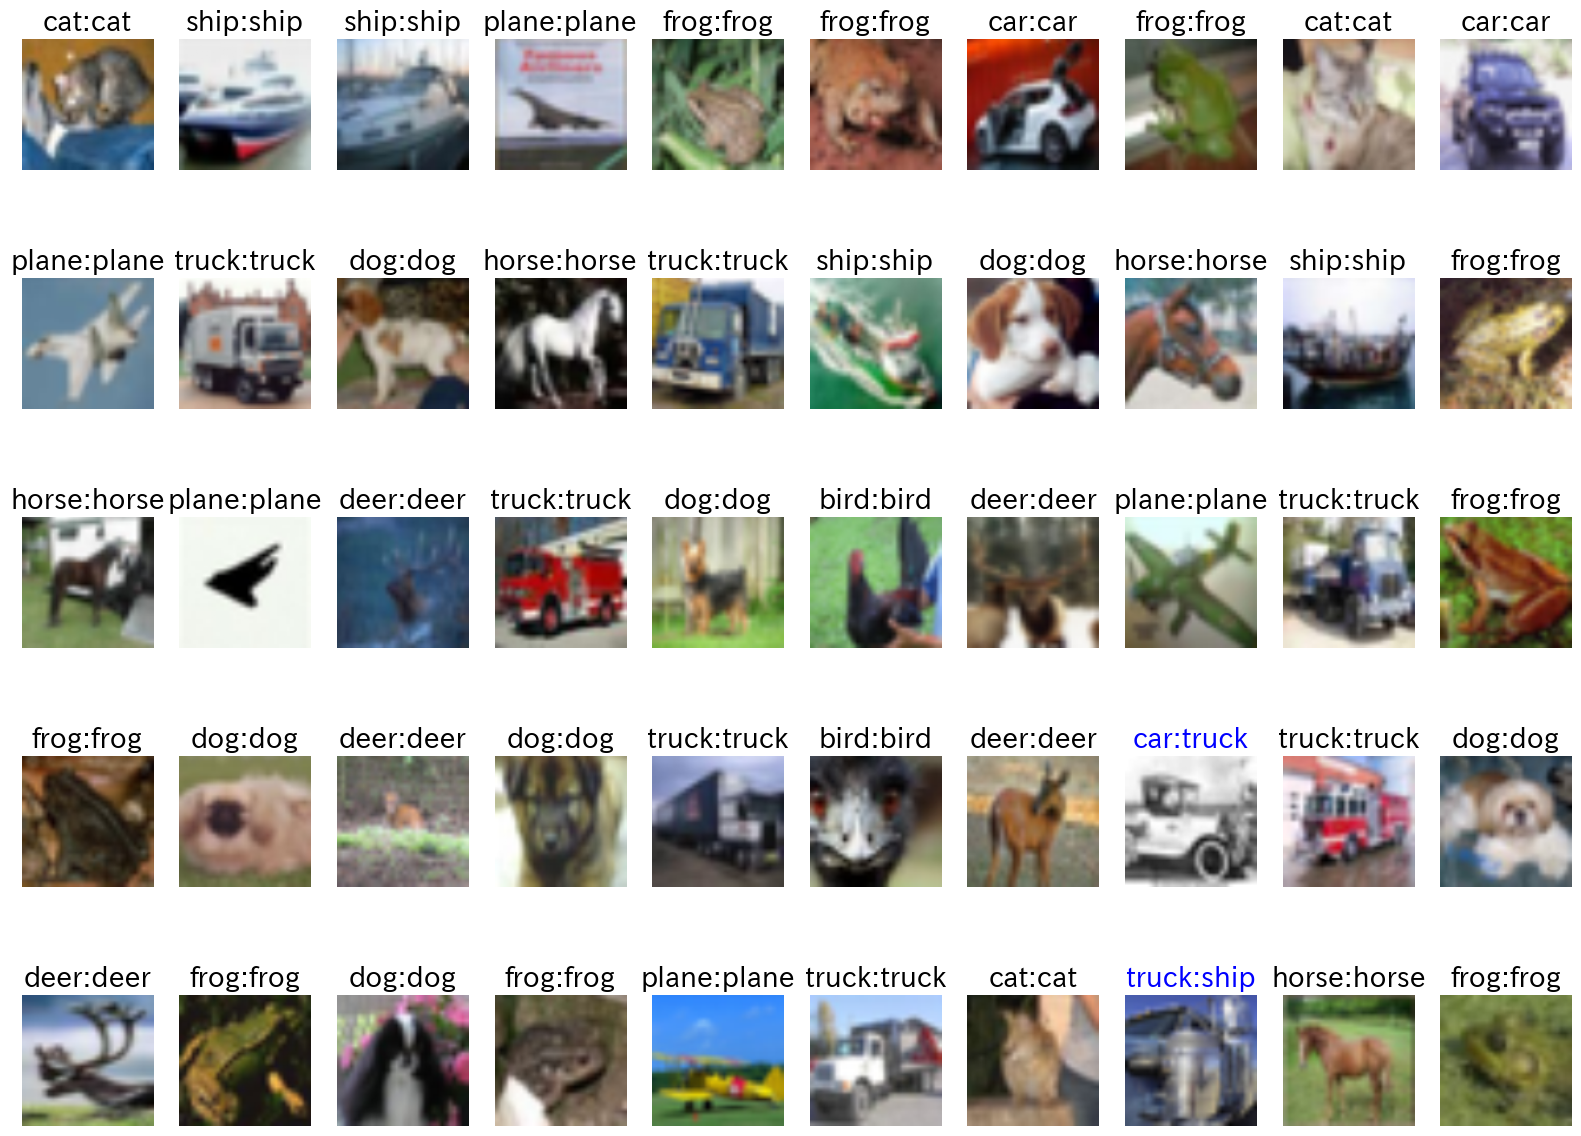

In [48]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

show_images_labels(test_loader, classes, net, device)